# Test for the cnn module

Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

The test consists of six model data sets.

First import the module.

In [1]:
import core.cnn as cnn

/home/janjoswig/.virtualenvs/CNN-5gkgQAOT/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [17]:
importlib.reload(cnn)

<module 'core.cnn' from '/home/janjoswig/CNN/core/cnn.py'>

Other import:

In [11]:
import importlib
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from itertools import cycle, islice

In [3]:
from matplotlib import cm
from pylab import rcParams
rcParams['figure.figsize'] = 6.50128*0.5, 6.50128*0.5*0.618*1.1
dpi = 300
rcParams['figure.dpi'] =  dpi
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Latin Modern Sans'

Set how many data points should be generated and a random seed.

In [18]:
noisy_circles, _ = datasets.make_circles(
    n_samples=200,
    factor=.5,
    noise=.05,
    random_state=8
    )

noisy_circles = StandardScaler().fit_transform(noisy_circles)

params = {
    'radius_cutoff': 0.4,
    'cnn_cutoff': 0,
    'member_cutoff': 1,
    'max_clusters': None
    }

cobj = cnn.CNN(train=noisy_circles)

cobj.fit(
    radius_cutoff=params['radius_cutoff'],
    cnn_cutoff=params['cnn_cutoff'],
    member_cutoff=params['member_cutoff'],
    max_clusters=params['max_clusters']
    )

color = ['#000000', '#396ab1', '#da7c30',
        '#3e9651', '#cc2529', '#535154',
        '#6b4c9a', '#922428', '#948b3d']

colors = np.array(
    list(islice(cycle(
        color
            ), int(max(cobj.train_labels) + 1)       
        ))
    )

Configuration file found in /home/janjoswig
Calculating nxn distance matrix for 200 points
Execution time for call of fit():     0 hours, 0 minutes, 0.0073 seconds
recording: ... 
points                  200
radius_cutoff           0.4
cnn_cutoff                0
member_cutoff             1
max_clusters           None
n_clusters                2
largest                 0.5
noise                     0
time             0.00733256
dtype: object


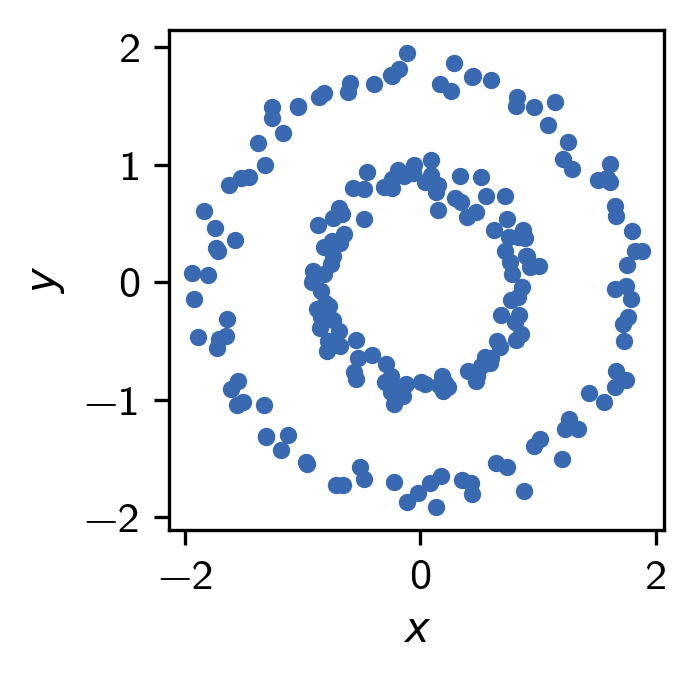

In [19]:
fig, ax = plt.subplots()
cobj.evaluate(ax=ax, annotate=False, plot="scatter", ax_props={"aspect": "equal"}, original=True)
fig.savefig(figdir / "circles.png")

In [12]:
figdir = Path("/home/janjoswig/Documents/Presentation/cnn/figures")

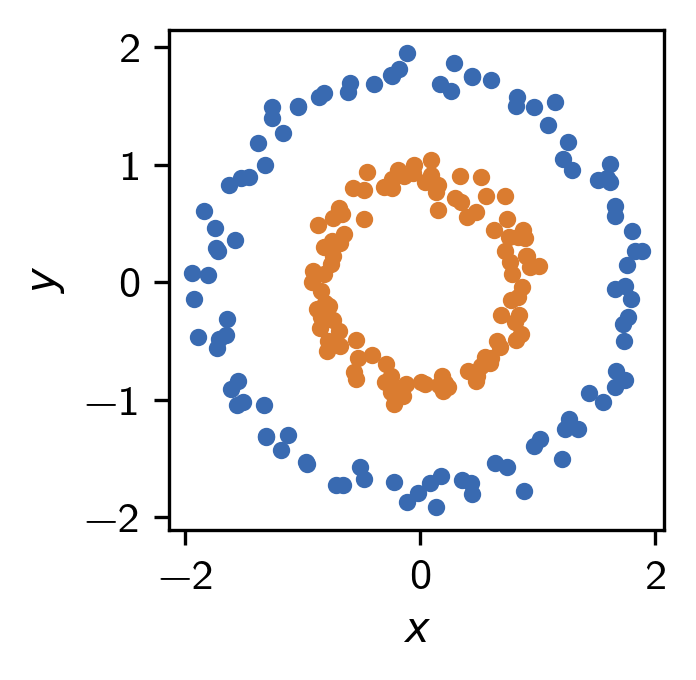

In [14]:
fig, ax = plt.subplots()
cobj.evaluate(ax=ax, annotate=False, plot="scatter", ax_props={"aspect": "equal"})
fig.savefig(figdir / "circles_clustered.png")

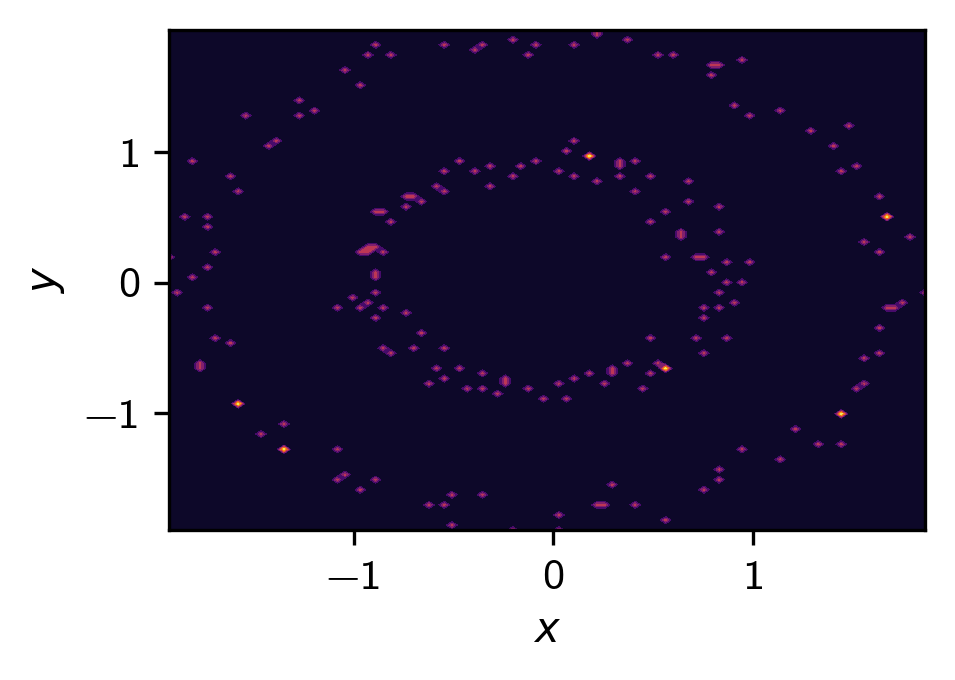

In [316]:
cobj.evaluate(plot='contourf', contour_props={'cmap': cm.inferno})

And take a look at the sets:

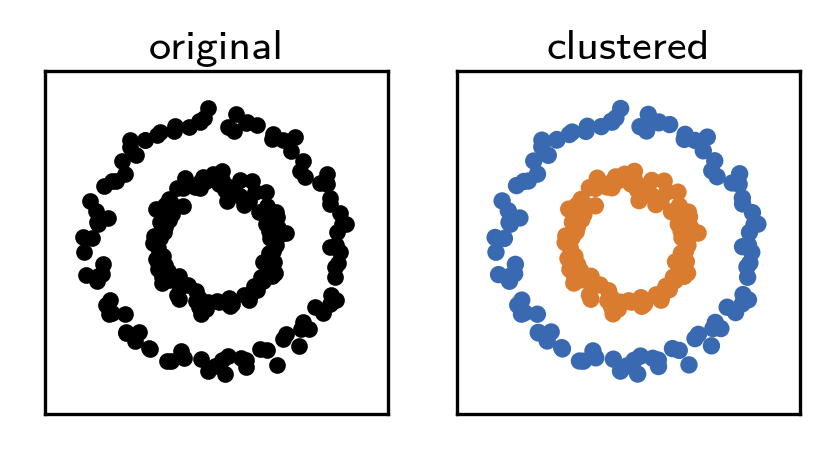

In [20]:
fig, ax = plt.subplots(1, 2)
Ax = ax.flatten()

Ax[0].plot(
    noisy_circles[:, 0],
    noisy_circles[:, 1],
    'k.')
Ax[0].set(**{
    "xticks": (),
    "yticks": (),
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "aspect": 'equal',
})

Ax[0].set_title("original", fontsize=10, pad=3)
          
Ax[1].scatter(
    noisy_circles[:, 0],
    noisy_circles[:, 1],
    s=10,
    color=colors[cobj.train_labels]
)
Ax[1].set(**{
    "xticks": (),
    "yticks": (),
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "aspect": 'equal',
})

Ax[1].set_title("clustered", fontsize=10, pad=3)
fig.savefig(figdir / "circles_example.png")

Next we specify the cluster parameters used for each set.

In [25]:
def plt_iteration(p, q=None, nn=None, cnn=None,
                  cdict=None, r=0.5,
                  data=noisy_circles, save=False,
                  o='iteration', limitf=1.4, **kwargs):
    fig, ax = plt.subplots()
    ax.scatter(
        data[:, 0], data[:, 1],
        s=8,
        color='black'
        )
    pcircle = plt.Circle(
        (data[p, 0], data[p, 1]),
        r,
        edgecolor='k',
        facecolor='none'
    )
    qcircle = plt.Circle(
        (data[q, 0], data[q, 1]),
        r,
        edgecolor='k',
        facecolor='none',
    )

    ax.plot(
        data[p, 0], data[p, 1],
        '.',
        markeredgecolor=color[3],
        markerfacecolor='none',
        alpha=0.75,
        ms=20
    )
    ax.add_artist(pcircle)
     
    if q is not None:
        ax.plot(
            data[q, 0], data[q, 1],
            '.',
            markeredgecolor=color[4],
            markerfacecolor='none',
            alpha=0.75,
            ms=20
        )
        ax.add_artist(qcircle)

    if nn is not None:
        ax.plot(
            data[nn, 0], data[nn, 1],
            '.',
            markeredgecolor=color[5],
            markerfacecolor='none',
            alpha=0.75,
            ms=14
        ) 

    if cnn is not None:
        ax.plot(
            data[cnn, 0], data[cnn, 1],
            '.',
            markeredgecolor=color[6],
            markerfacecolor='none',
            alpha=0.75,
            ms=12
        )
    
    if cdict is not None:
        for label, cluster in cdict.items():
            ax.scatter(
                data[cluster, 0],
                data[cluster, 1],
                s=10,
                color=color[label],
            )
    
    ax.set(**{
        "aspect": 'equal',
        "xlim": (data[p, 0]-limitf*r, data[p, 0]+limitf*r),
        "ylim": (data[p, 1]-limitf*r, data[p, 1]+limitf*r),
        "xticks": (),
        "yticks": (),
    })

    if save:
        fig.savefig(figdir / f"{o}", dpi=dpi)


# 1

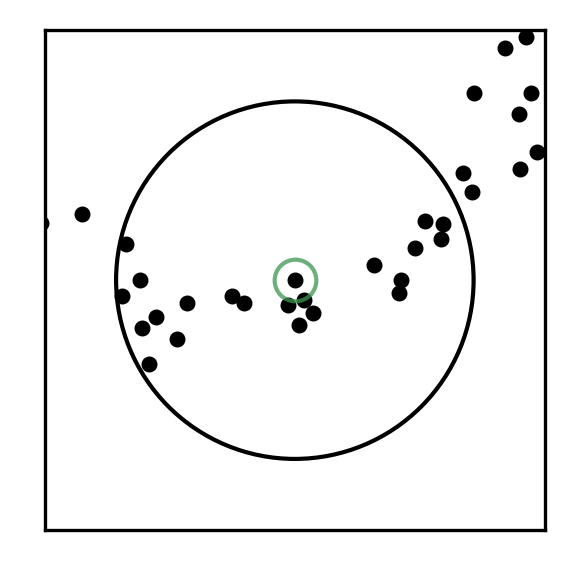

In [28]:
plt_iteration(173, save=True, o="initial")

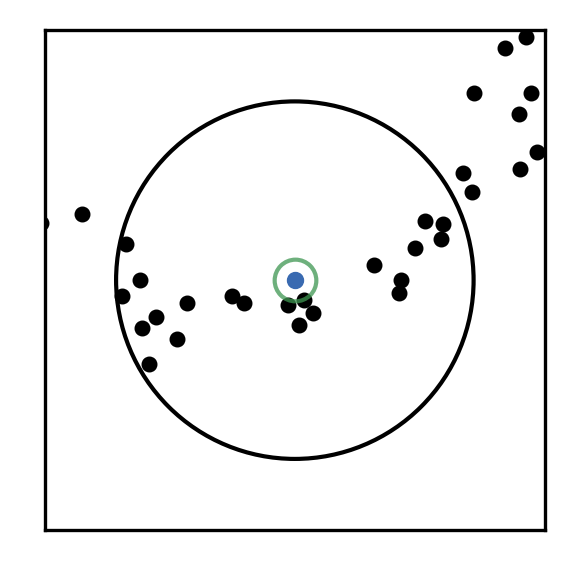

In [29]:
plt_iteration(173, cdict={1: [173]}, save=True, o="initial_assigned")

# 2

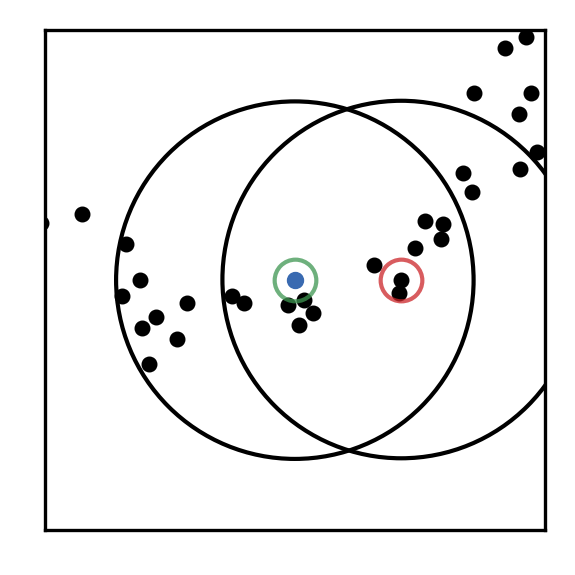

In [30]:
plt_iteration(173, 8, cdict={1: [173]}, save=True, o="candidate")

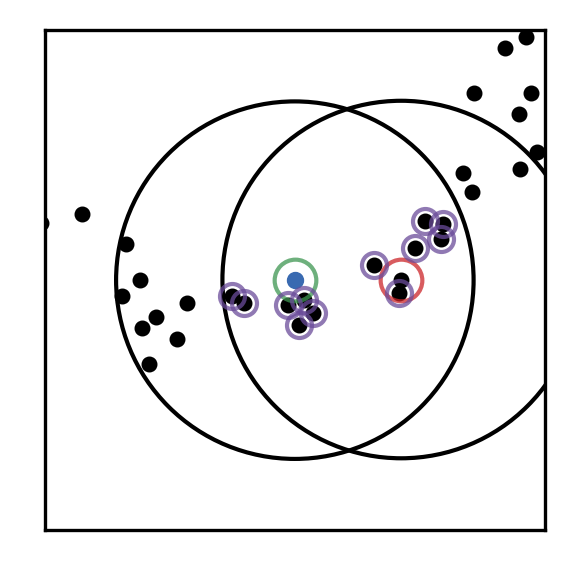

In [31]:
plt_iteration(
    173, 8,
    cnn=[98, 100, 69, 168, 27, 113, 115, 85, 26, 187, 60, 63,],
    cdict={1: [173]},
    save=True,
    o="candidate_neighbours"
)

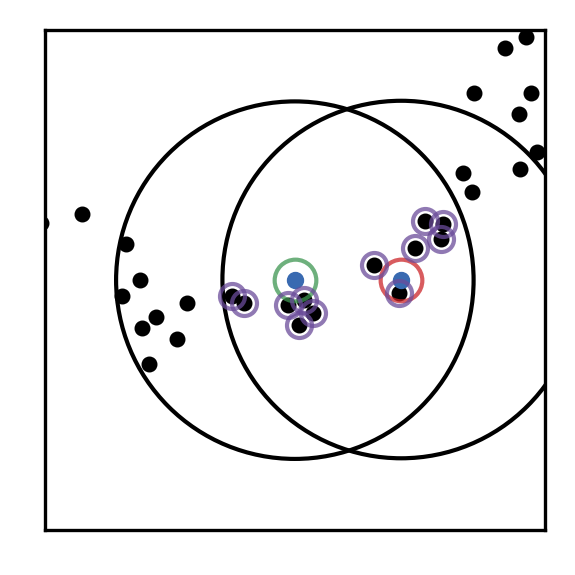

In [32]:
plt_iteration(
    173, 8,
    cnn=[98, 100, 69, 168, 27, 113, 115, 85, 26, 187, 60, 63,],
    cdict={1: [173, 8]},
    save=True, o="candidate_assigned"
)

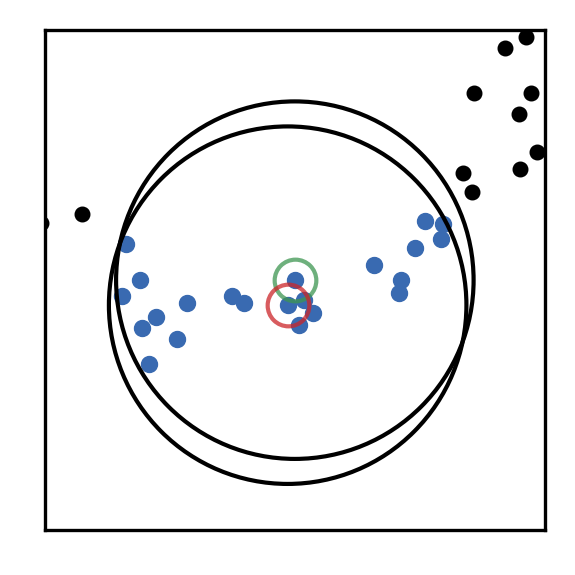

In [33]:
plt_iteration(
    173, 187,
    cdict={1: [8, 10, 26, 27, 30, 32, 50, 60, 63, 69, 85, 98, 100, 113, 115, 128, 135, 163, 164, 168, 173, 187]},
    save=True, o="further_assigned"
)



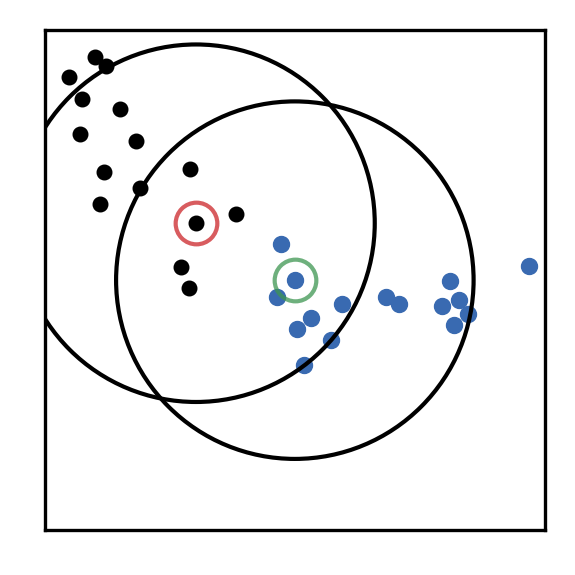

In [34]:
plt_iteration(
    10, 3,
    cdict={1: [8, 10, 26, 27, 30, 32, 50, 60, 63, 69, 85, 98, 100, 113, 115, 128, 135, 163, 164, 168, 173, 187]},
    save=True, o="grow_candidate"
)


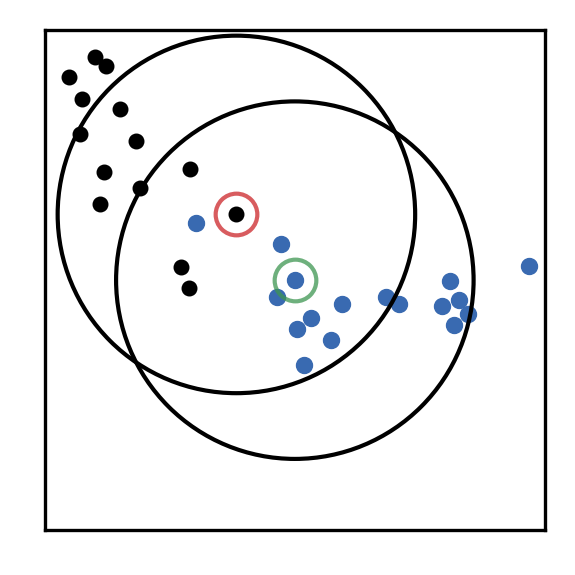

In [35]:
plt_iteration(
    10, 108,
    cdict={1: [3, 8, 10, 26, 27, 30, 32, 50, 60, 63, 69, 85, 98, 100, 113, 115, 128, 135, 163, 164, 168, 173, 187]},
    save=True, o="grow_candidate_assigned"
)

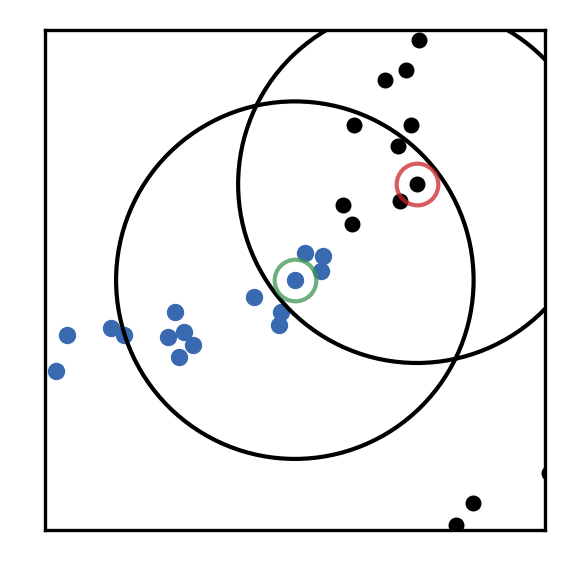

In [36]:
plt_iteration(
    27, 2,
    cdict={1: [3, 8, 10, 26, 27, 30, 32, 50, 60, 63, 69, 85, 98, 100, 113, 115, 128, 135, 163, 164, 168, 173, 187]},
    save=True, o="grow_further"
)

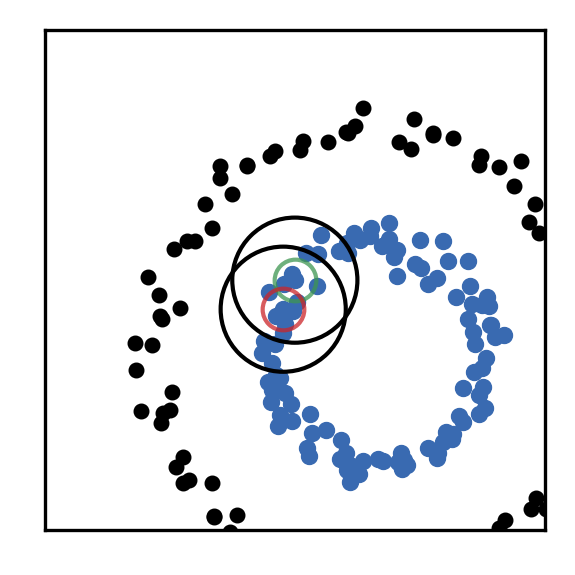

In [37]:
plt_iteration(
    195, 180,
    cdict={1: [2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 19, 21, 23, 24, 25, 26, 27, 28, 30, 32, 34, 39, 42, 43, 44, 46, 47, 50, 56, 57, 59, 60, 61, 63, 64, 66, 69, 70, 71, 72, 79, 82, 85, 88, 91, 95, 96, 98, 100, 103, 107, 108, 110, 113, 115, 116, 117, 118, 119, 121, 122, 124, 126, 127, 128, 130, 134, 135, 137, 140, 142, 143, 144, 145, 148, 150, 160, 162, 163, 164, 166, 167, 168, 173, 174, 180, 182, 184, 185, 186, 187, 190, 192, 193, 195, 196, 197, 199]},
    limitf=4,
    save=True, o="cluster1_done"
)


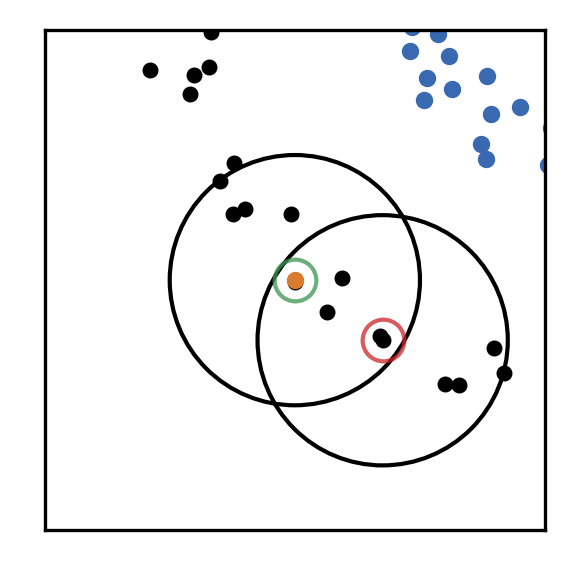

In [38]:
plt_iteration(
    4, 0,
    cdict={
        1: [2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 19, 21, 23, 24, 25, 26, 27, 28, 30, 32, 34, 39, 42, 43, 44, 46, 47, 50, 56, 57, 59, 60, 61, 63, 64, 66, 69, 70, 71, 72, 79, 82, 85, 88, 91, 95, 96, 98, 100, 103, 107, 108, 110, 113, 115, 116, 117, 118, 119, 121, 122, 124, 126, 127, 128, 130, 134, 135, 137, 140, 142, 143, 144, 145, 148, 150, 160, 162, 163, 164, 166, 167, 168, 173, 174, 180, 182, 184, 185, 186, 187, 190, 192, 193, 195, 196, 197, 199],
        2: [4]
    },
    limitf=2,
    save=True, o="init_cluster2"
)

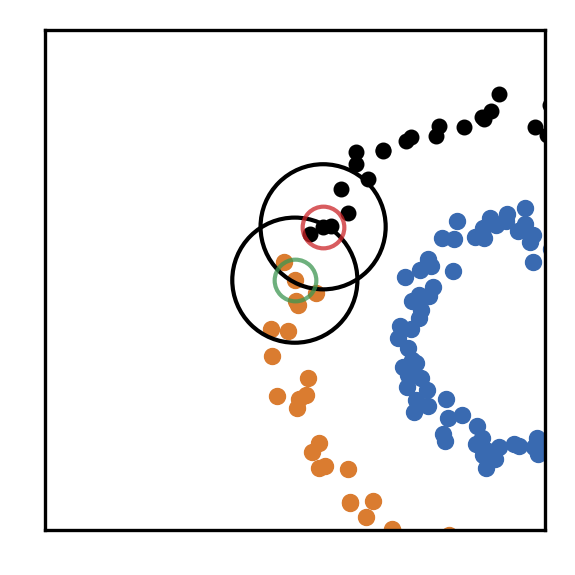

In [39]:
plt_iteration(
    29, 20,
    cdict={
        1: [2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 19, 21, 23, 24, 25, 26, 27, 28, 30, 32, 34, 39, 42, 43, 44, 46, 47, 50, 56, 57, 59, 60, 61, 63, 64, 66, 69, 70, 71, 72, 79, 82, 85, 88, 91, 95, 96, 98, 100, 103, 107, 108, 110, 113, 115, 116, 117, 118, 119, 121, 122, 124, 126, 127, 128, 130, 134, 135, 137, 140, 142, 143, 144, 145, 148, 150, 160, 162, 163, 164, 166, 167, 168, 173, 174, 180, 182, 184, 185, 186, 187, 190, 192, 193, 195, 196, 197, 199],
        2: [0, 1, 4, 29, 35, 37, 49, 54, 68, 75, 78, 83, 84, 94, 101, 120, 132, 136, 138, 149, 151, 157, 165, 169, 170, 171, 177, 181, 188, 191,]
    },
    limitf=4,
    save=True, o="grow_cluster2"
)